conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
di['bestROIs']=('GM_19.nii.gz', 'GM_225.nii.gz', 'GM_86.nii.gz', 'GM_159.nii.gz', 'GM_65.nii.gz', 'GM_235.nii.gz', 'GM_108.nii.gz', 'GM_76.nii.gz', 'GM_166.nii.gz', 'GM_271.nii.gz', 'GM_164.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_21.nii.gz', 'GM_126.nii.gz', 'GM_58.nii.gz', 'GM_93.nii.gz', 'GM_67.nii.gz', 'GM_209.nii.gz', 'GM_230.nii.gz', 'GM_265.nii.gz', 'GM_220.nii.gz', 'GM_263.nii.gz', 'GM_246.nii.gz', 'GM_243.nii.gz')
di['bestROIs']=('GM_234.nii.gz', 'GM_19.nii.gz', 'GM_86.nii.gz', 'GM_240.nii.gz', 'GM_114.nii.gz', 'GM_65.nii.gz', 'GM_284.nii.gz', 'GM_139.nii.gz', 'GM_295.nii.gz', 'GM_258.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_41.nii.gz', 'GM_132.nii.gz', 'GM_249.nii.gz', 'GM_49.nii.gz', 'GM_190.nii.gz', 'GM_93.nii.gz', 'GM_67.nii.gz', 'GM_265.nii.gz', 'GM_52.nii.gz', 'GM_146.nii.gz', 'GM_238.nii.gz', 'GM_263.nii.gz', 'GM_150.nii.gz', 'GM_281.nii.gz', 'GM_244.nii.gz', 'GM_30.nii.gz', 'GM_79.nii.gz')
di

6--LENGTH OF TR: 80
shape of features (80, 8204) shape of chosenMask (94, 94, 72)
(80, 8204)
(80, 2)
FEAT.shape=(80, 8204)
floor=0, ceil=0.1704018019671017
mu=0.08520090098355085, sig=0.07236359859312964
6--LENGTH OF TR: 80
shape of features (80, 7209) shape of chosenMask (94, 94, 72)
(80, 7209)
(80, 2)
FEAT.shape=(80, 7209)
floor=0, ceil=0.015473825479978038
mu=0.007736912739989019, sig=0.006571184593162068
6--LENGTH OF TR: 80
shape of features (80, 8554) shape of chosenMask (94, 94, 72)
(80, 8554)
(80, 2)
FEAT.shape=(80, 8554)
floor=0, ceil=0.156277891292176
mu=0.078138945646088, sig=0.06636567491599117
6--LENGTH OF TR: 80
shape of features (80, 5739) shape of chosenMask (94, 94, 72)
(80, 5739)
(80, 2)
FEAT.shape=(80, 5739)
floor=0, ceil=0.1234585334065389
mu=0.06172926670326945, sig=0.05242845821578856
6--LENGTH OF TR: 80
shape of features (80, 4591) shape of chosenMask (94, 94, 72)
(80, 4591)
(80, 2)
FEAT.shape=(80, 4591)
floor=0, ceil=0.23871839204563827
mu=0.11935919602281914, si

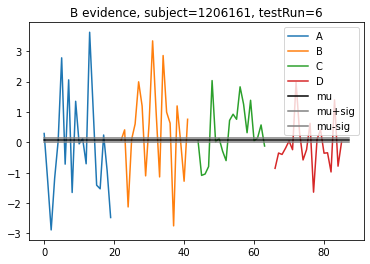

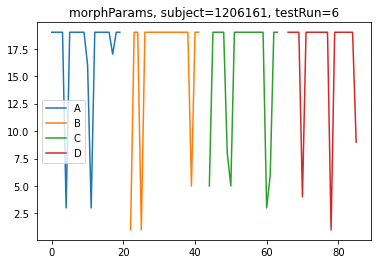

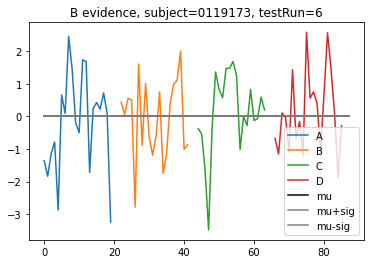

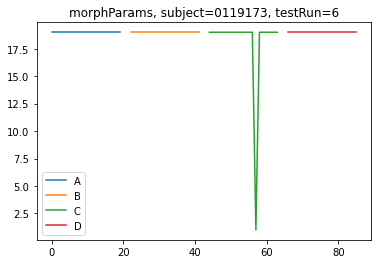

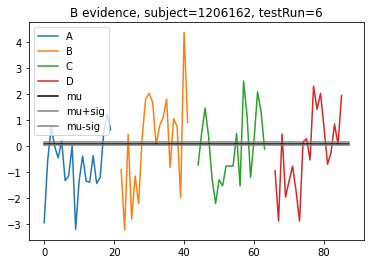

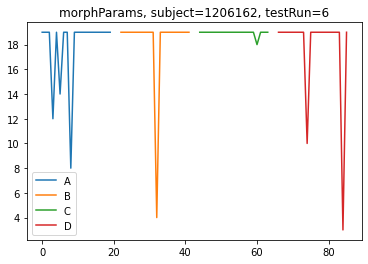

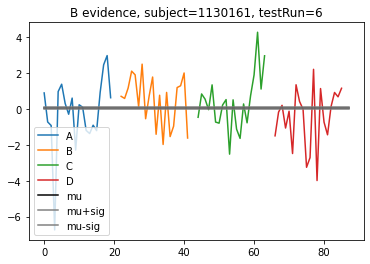

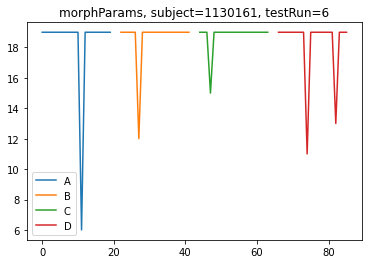

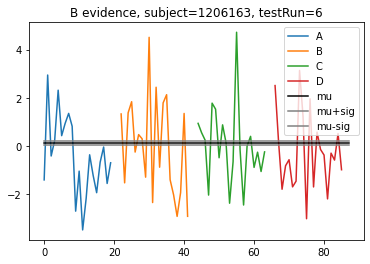

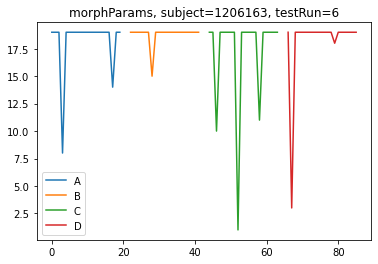

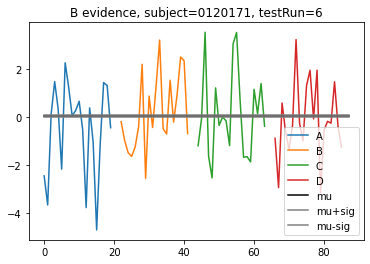

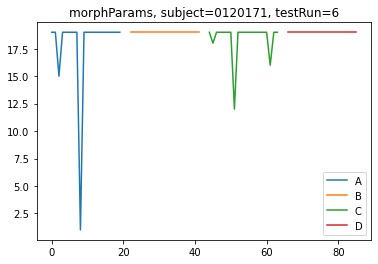

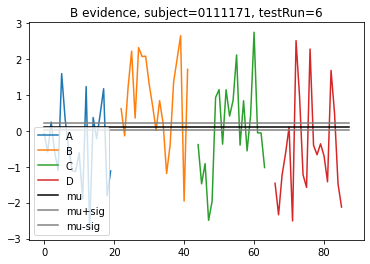

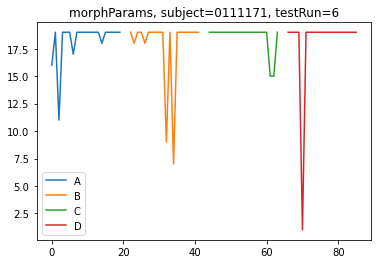

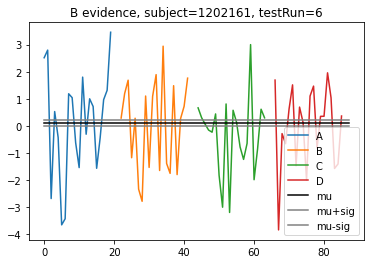

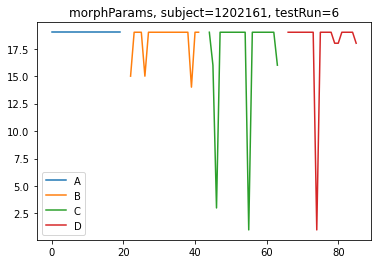

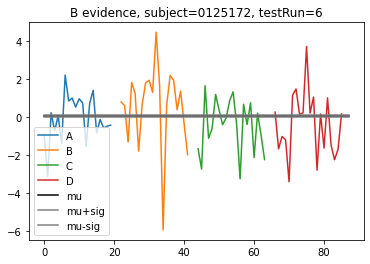

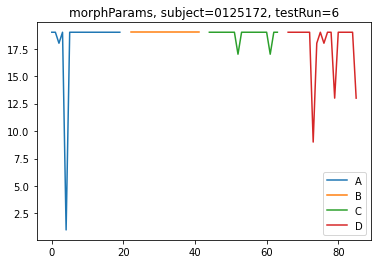

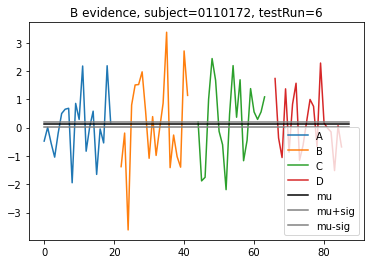

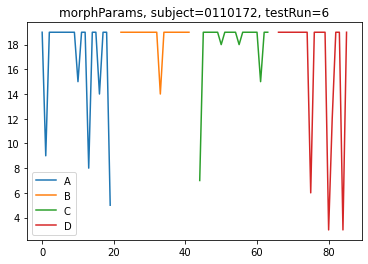

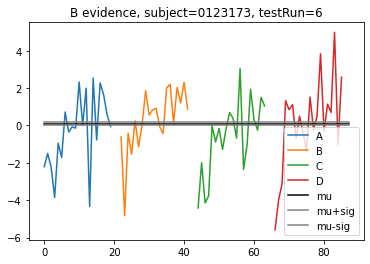

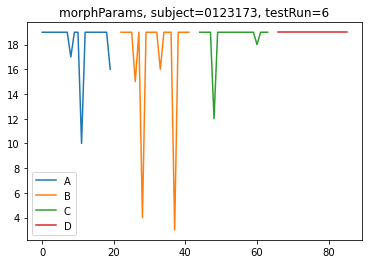

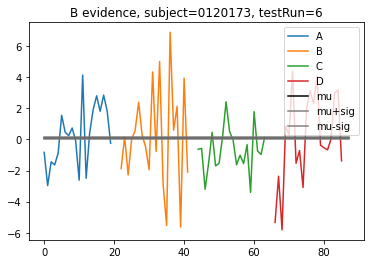

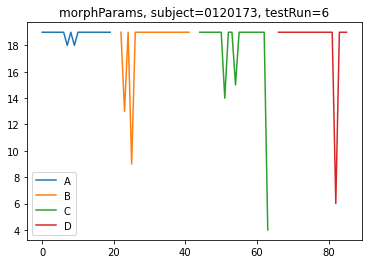

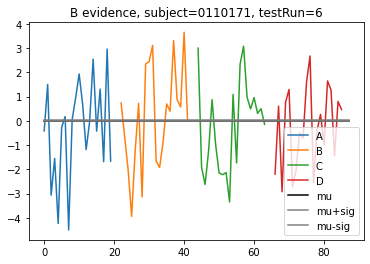

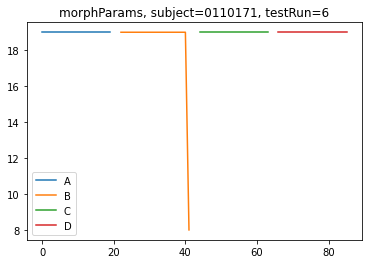

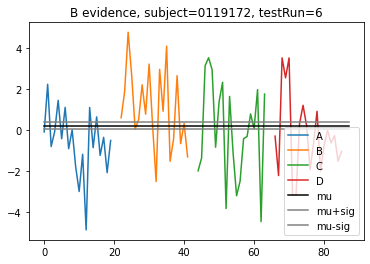

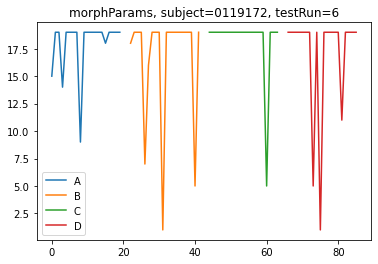

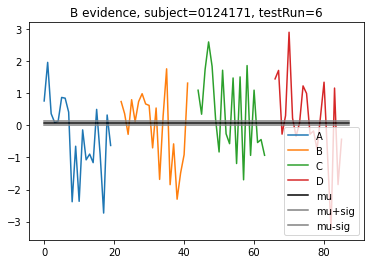

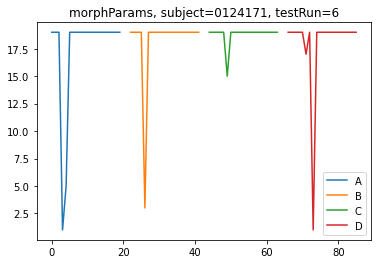

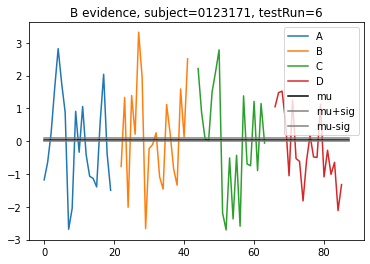

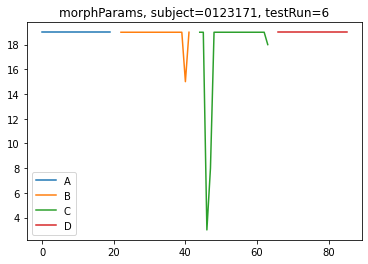

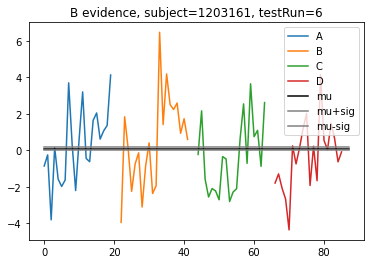

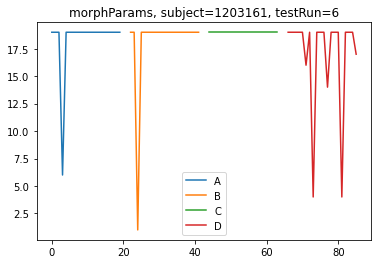

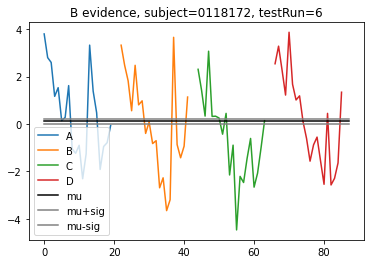

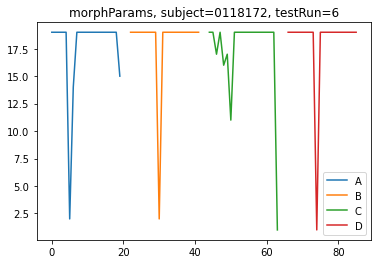

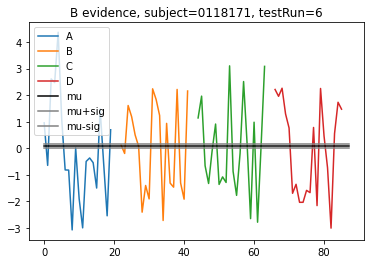

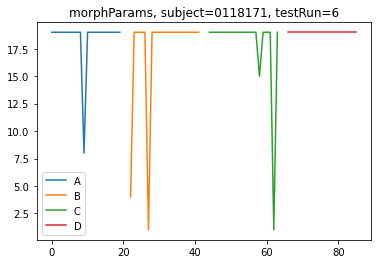

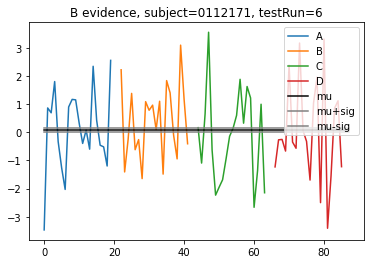

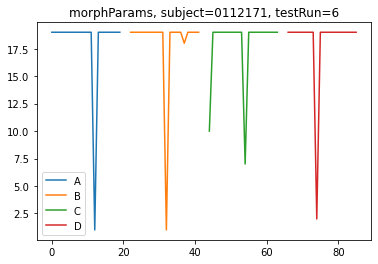

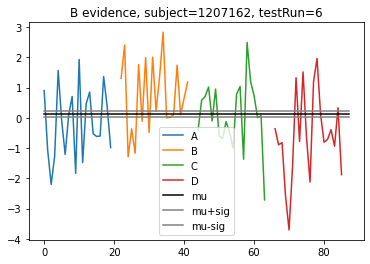

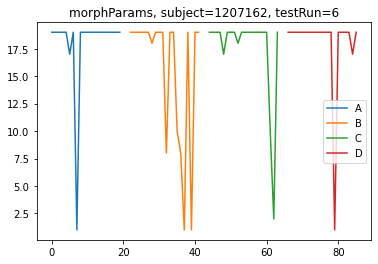

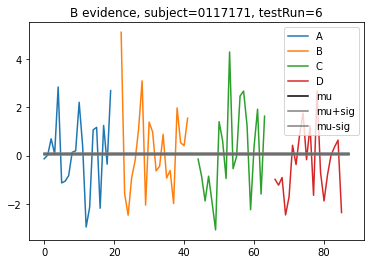

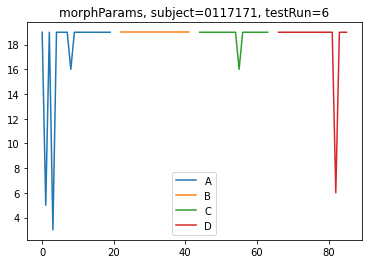

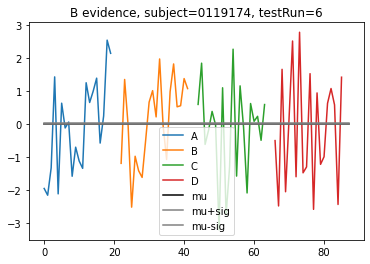

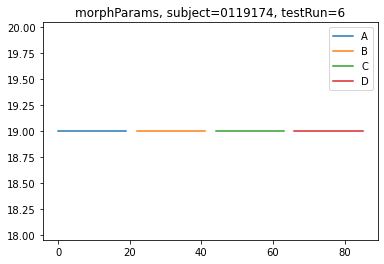

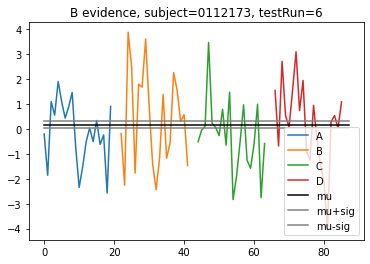

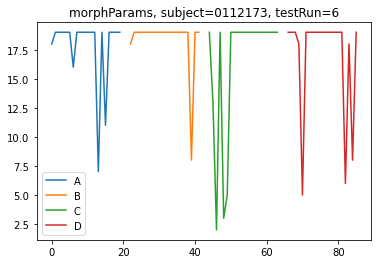

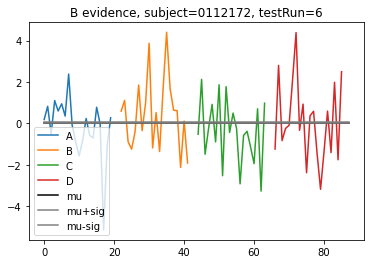

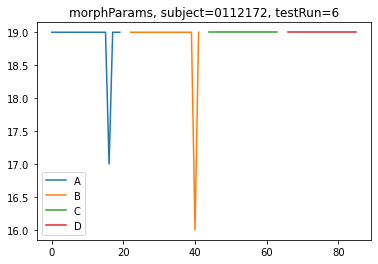

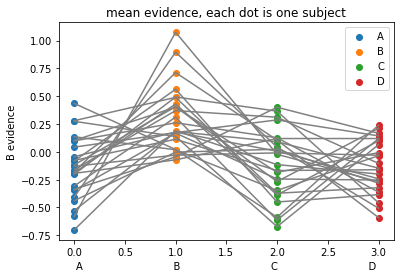

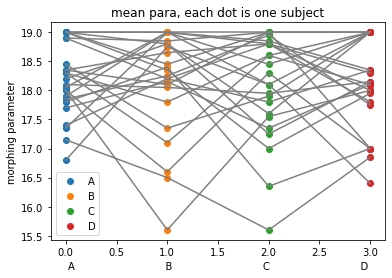

In [5]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
def logit(p):
    return np.log(p/(1-p))
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=78
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
tag="GM"
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+f"./{roiloc}/{subject}/output/uniMaskRank_{tag}_top{N}.npy")
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']
    print(f"di['bestROIs']={di['bestROIs']}")

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask_{tag}",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask_{tag}.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    def RTnormalize(features):
        raw = np.expand_dims(features[0], 0)
        acc_norm_data=raw
        for curr_TR in range(1,features.shape[0]):
            raw = np.concatenate((raw,np.expand_dims(features[curr_TR],0)),axis=0)
            raw_normalized=raw.copy()
            raw_normalized=normalize(raw_normalized)
            acc_norm_data = np.concatenate((acc_norm_data,np.expand_dims(raw_normalized[-1],0)),axis=0)
            print(acc_norm_data.shape)
        return acc_norm_data

    def shuffleWithinEachRow(array):
        import random 
        new=np.zeros(array.shape)
        for i in range(array.shape[0]):
            t=list(array[i])
            random.shuffle(t)
            new[i]=t
        return new

    # 全局的归一化
    features = normalize(features)
    # 只考虑已经收集到数据的RT模式的归一化
    # features = RTnormalize(features)
    # 对于每一个TR，打乱其内部的voxel的顺序，以达到噪声的水平
#     features = shuffleWithinEachRow(features)


    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        BX=np.log(p/(1-p))
        return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    A_ID = (META['label']=='bed')
    X_A = FEAT[A_ID]

    B_ID = (META['label']=='chair')
    X_B = FEAT[B_ID]

    C_ID = (META['label']=='table')
    X_C = FEAT[C_ID]

    D_ID = (META['label']=='bench')
    X_D = FEAT[D_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
    ceilings={'1206161': 0.1704018019671017,
    '0119173': 0.015473825479978038,
    '1206162': 0.156277891292176,
    '1130161': 0.1234585334065389,
    '1206163': 0.23871839204563827,
    '0120171': 0.09837705349563342,
    '0111171': 0.23528731137622036,
    '1202161': 0.23130485589191493,
    '0125172': 0.13846164383941578,
    '0110172': 0.23388283785077046,
    '0123173': 0.20108707419544591,
    '0120173': 0.1512688639136599,
    '0110171': 0.02098889405777557,
    '0119172': 0.40217563355892294,
    '0124171': 0.15899675598518231,
    '0123171': 0.10188696143122584,
    '1203161': 0.19378255742049785,
    '0118172': 0.24137653795983605,
    '0118171': 0.15063441599697375,
    '0112171': 0.1675121356064939,
    '1207162': 0.2332026859351661,
    '0117171': 0.10311784816750072,
    '0119174': 0.03493032693679105,
    '0112173': 0.3324759723502478,
    '0112172': 0.08287185584068701}
    ceil=ceilings[subject]
    floor=0
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")


    BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]

    def BEvi(X):
        # print(f"classifierEvidence(BC_clf,X,Y)={classifierEvidence(BC_clf,X,Y)}")
        # print(f"classifierEvidence(BD_clf,X,Y)={classifierEvidence(BD_clf,X,Y)}")
        BC_B_evidence = classifierEvidence(BC_clf,X,'chair')
        BD_B_evidence = classifierEvidence(BD_clf,X,'chair')
        # print(f"BC_B_evidence={BC_B_evidence}")
        # print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        morphParam=gaussian(B_evidence, mu, sig)
        return B_evidence , morphParam
            
    B_evidences , morphParams=[],[]
    for X in [X_A,X_B,X_C,X_D]:
        B_evidence , morphParam = BEvi(X)
        B_evidences.append(B_evidence) 
        morphParams.append(morphParam)

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(B_evidences[i])) , B_evidences[i],label=label)
        start=start+len(B_evidences[i])+2
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu],label="mu",c="black")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu+sig],label="mu+sig",c="grey")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu-sig],label="mu-sig",c="grey")
    plt.legend()
    plt.title(f"B evidence, subject={subject}, testRun={testRun}")

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(morphParams[i])) , morphParams[i],label=label)
        start=start+len(morphParams[i])+2
    plt.legend()
    plt.title(f"morphParams, subject={subject}, testRun={testRun}")


    # store="\n"
    # print("floor")
    # # D evidence for AD_clf when A is presented.
    # Y = 'bench'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierProb(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    # store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # # C evidence for AC_clf when A is presented.
    # Y = 'table'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_C_evidence = classifierProb(AC_clf,X,Y)
    # evidence_floor = np.mean(AC_C_evidence)
    # print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    # store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # # D evidence for CD_clf when A is presented.
    # Y = 'bench'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor1 = np.mean(CD_D_evidence)
    # print(f"D evidence for CD_clf when A is presented={evidence_floor1}")
    # store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor1}"

    # # C evidence for CD_clf when A is presented.
    # Y = 'table'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor2 = np.mean(CD_C_evidence)
    # print(f"C evidence for CD_clf when A is presented={evidence_floor2}")
    # store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor2}"

    # # set floor to be 0, (aka before inverting is 0.5) and only estimate ceiling # edited 03152021
    # evidence_floor = 0.5 #max(evidence_floor1,evidence_floor2)
    # store=store+f"\nmax(evidence_floor1,evidence_floor2)={evidence_floor} unique_Mark"


    # print("ceil")
    # store=store+"\n"+"ceil"
    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = 'bed'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierProb(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    # store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    # Y = 'bed'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierProb(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    # store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil} uniqueMark")
    # store=store+f"\nevidence_ceil={evidence_ceil} uniqueMark"

    # ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    # mu = (ceil+floor)/2
    # sig = (ceil-floor)/2.3548
    # print(f"floor={floor}, ceil={ceil}")
    # print(f"mu={mu}, sig={sig}")

    # store=store+"\n"+f"floor={floor}, ceil={ceil}"
    # store=store+"\n"+f"mu={mu}, sig={sig}"


    # BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # Y = 'chair'
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    # print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")


    # # # convert item colume to label colume
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # def testMorphParamFor(A): #A='bed''chair'...
    #     A_ID = (META['label']==A)
    #     X = FEAT[A_ID]


    #     # 这里的X是选择的testRun里面的所有的展示A的trials
    #     BC_B_evidence = classifierProb(BC_clf,X,Y)
    #     BD_B_evidence = classifierProb(BD_clf,X,Y)
    #     print(f"BC_B_evidence={BC_B_evidence}")
    #     print(f"BD_B_evidence={BD_B_evidence}")
    #     B_evidence = (BC_B_evidence+BD_B_evidence)/2
    #     print(f"B_evidence={B_evidence}")
    #     print(f"mu={mu}, sig={sig}")
        



    #     morphParam=np.mean(gaussian(B_evidence, mu, sig))
    #     # B_evidences.append(B_evidence)
    #     print(f"morphParam={morphParam}")
    #     return f"morphParam for {A} = {morphParam}"

    # store=store+"\n"+testMorphParamFor('bed')
    # store=store+"\n"+testMorphParamFor('chair')
    # store=store+"\n"+testMorphParamFor('table')
    # store=store+"\n"+testMorphParamFor('bench')

    return B_evidences,morphParams

Evidence={}
for sub in subjects:
    Evidence[sub] = morphingTarget(sub)

# 画evidence的总结图
mean_evidence=np.zeros((len(subjects),4))
for ii,sub in enumerate(subjects):
    mean_evidence[ii]=[np.mean(evidence) for evidence in Evidence[sub][0]]

plt.figure()
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_evidence[:,i],label=label)

plt.legend()
plt.title("mean evidence, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("B evidence")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_evidence[ii],c="grey")

# 画morphing parameter的总结图
mean_para=np.zeros((len(subjects),4))
for ii,sub in enumerate(subjects):
    mean_para[ii]=[np.mean(para) for para in Evidence[sub][1]]

plt.figure()
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_para[:,i],label=label)

plt.legend()
plt.title("mean para, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("morphing parameter")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_para[ii],c="grey")


In [7]:
np.mean(mean_evidence,axis=0)

array([-0.14596475,  0.29764151, -0.10236028, -0.12763036])